# Unsupervised Clustering - Student Segmentation

## Objective
Segment students into distinct learning personas using K-Means clustering based on behavioural features.

## CRISP-DM Stage
Modelling and Evaluation

## Methods
- Feature selection and standardisation
- Elbow Method for optimal k determination
- Silhouette Score analysis
- K-Means clustering
- PCA visualisation
- Cluster profiling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load and Prepare Clustering Features

Create 4 simple, interpretable features for student segmentation.

In [2]:
print('\n' + '=' * 80)
print('CLUSTERING: LOADING PRE-COMPUTED FEATURES')
print('=' * 80)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load Pre-computed Features
try:
    print("Loading clustering features from disk...")
    # Adjust path if needed. Notebooks are in 1_Notebooks, Outputs in 2_Outputs
    df_features = pd.read_pickle('../2_Outputs/clustering_features.pkl')
    print(f"Features loaded. Shape: {df_features.shape}")
except FileNotFoundError:
    print("Error: 'clustering_features.pkl' not found in ../2_Outputs/")
    raise

# Define the features list
clustering_features = ['Intensity', 'Regularity', 'Procrastination', 'Breadth']
X_clustering = df_features[clustering_features]

print(f'\nFeature Statistics (Raw):')
print(X_clustering.describe().round(2))

# Scale the Data
scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

# Update df_encoded context for compatibility with later cells
# In the original flow, df_encoded was a copy of the features DF 
# that only contained keys + features. This preserves that state.
df_encoded = df_features.copy() 

print(f'\nScaled features shape: {X_clustering_scaled.shape}')
print('✓ Features ready for clustering.')


CLUSTERING: LOADING PRE-COMPUTED FEATURES
Loading clustering features from disk...
Features loaded. Shape: (29278, 7)

Feature Statistics (Raw):
       Intensity  Regularity  Procrastination   Breadth
count   29278.00    29278.00         29278.00  29278.00
mean     1352.73        3.24           -10.53     66.96
std      1732.97        3.91            25.07     54.98
min         0.00        0.00          -236.00      0.00
25%       258.00        1.33            -5.71     27.00
50%       738.00        2.28             0.00     51.00
75%      1768.75        3.80             1.20     92.00
max     24139.00      111.72           187.00    413.00

Scaled features shape: (29278, 4)
✓ Features ready for clustering.


## Section 2: Determine Optimal Clusters - Elbow Method

Identify optimal number of clusters by analysing within-cluster sum of squares.


ELBOW METHOD FOR OPTIMAL K
k=2: Inertia = 75713.8346
k=3: Inertia = 61961.7042
k=4: Inertia = 50286.2366
k=5: Inertia = 40610.3789
k=6: Inertia = 34659.3907
k=7: Inertia = 31175.4481
k=8: Inertia = 28022.2954
k=9: Inertia = 25533.4129
k=10: Inertia = 23117.3936


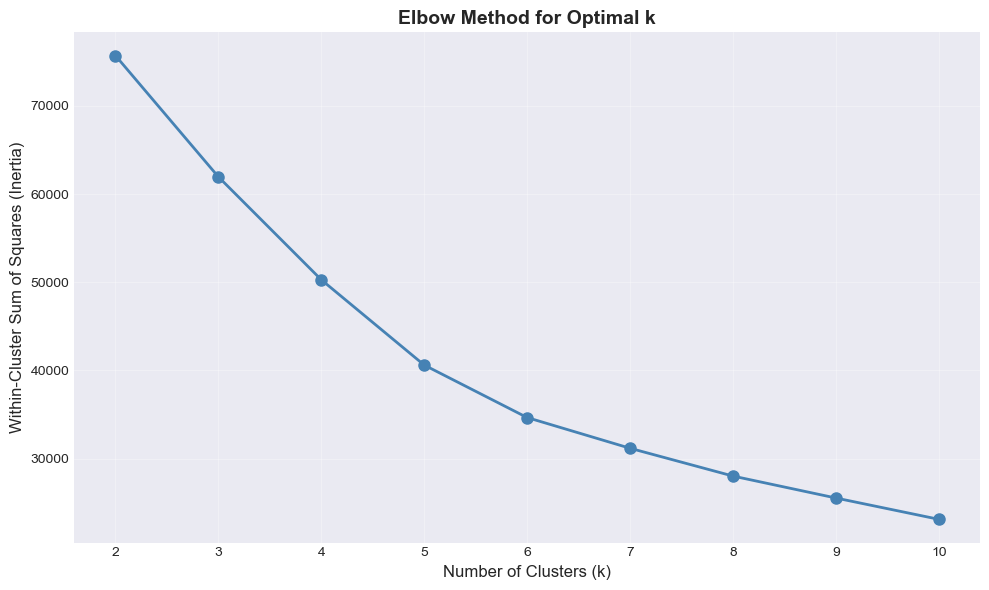

In [3]:
print('\n' + '=' * 80)
print('ELBOW METHOD FOR OPTIMAL K')
print('=' * 80)

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    print(f'k={k}: Inertia = {kmeans.inertia_:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

## Section 3: Determine Optimal Clusters - Silhouette Score

Evaluate cluster quality using Silhouette Score analysis.


SILHOUETTE SCORE FOR OPTIMAL K
Calculating Silhouette Scores (using sample_size=5000 for performance)...
k=2: Silhouette Score = 0.5009
k=3: Silhouette Score = 0.5095
k=4: Silhouette Score = 0.3652
k=5: Silhouette Score = 0.3823
k=6: Silhouette Score = 0.3883
k=7: Silhouette Score = 0.3227
k=8: Silhouette Score = 0.3297
k=9: Silhouette Score = 0.3172
k=10: Silhouette Score = 0.3308

Optimal k (based on Silhouette Score): 3


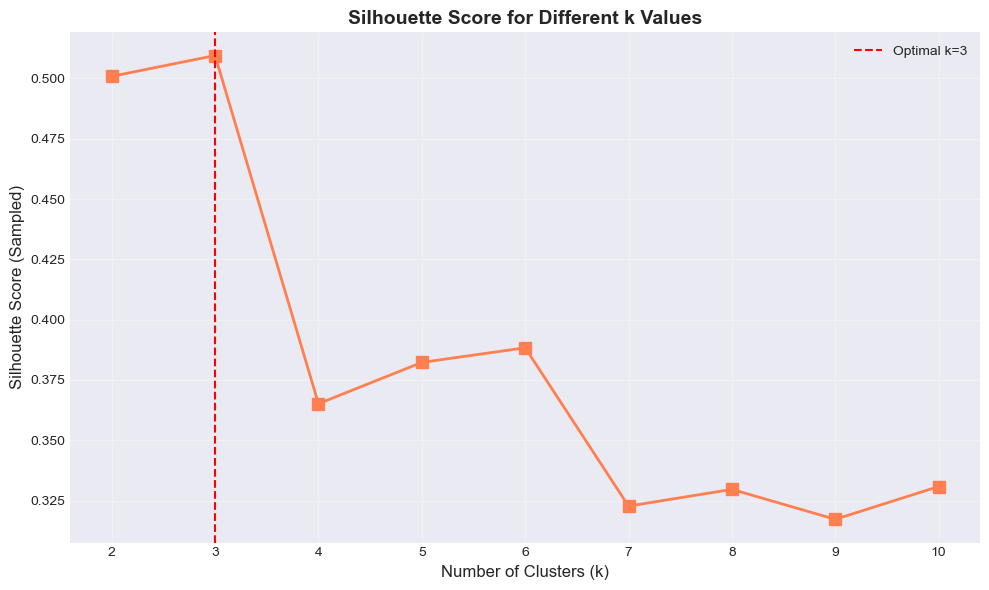

In [4]:
print('\n' + '=' * 80)
print('SILHOUETTE SCORE FOR OPTIMAL K')
print('=' * 80)

silhouette_scores = []

# Use a sample for silhouette score to avoid MemoryError on large datasets
sample_size = 5000
print(f"Calculating Silhouette Scores (using sample_size={sample_size} for performance)...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering_scaled)
    
    # Use sample_size to speed up and save memory
    if len(X_clustering_scaled) > sample_size:
        silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels, sample_size=sample_size, random_state=42)
    else:
        silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
        
    silhouette_scores.append(silhouette_avg)
    print(f'k={k}: Silhouette Score = {silhouette_avg:.4f}')

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f'\nOptimal k (based on Silhouette Score): {optimal_k_silhouette}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='coral')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score (Sampled)', fontsize=12)
plt.title('Silhouette Score for Different k Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.legend()
plt.tight_layout()
plt.show()

## Section 4: K-Means Clustering

Implement K-Means with optimal number of clusters.

In [5]:
print('\n' + '=' * 80)
print('K-MEANS CLUSTERING')
print('=' * 80)

optimal_k = 3 # Update based on silhouette score

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering_scaled)

df_encoded['cluster'] = cluster_labels

print(f'K-Means converged in {kmeans_final.n_iter_} iterations')
print(f'\nCluster Distribution:')
print(df_encoded['cluster'].value_counts().sort_index())

silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
print(f'\nSilhouette Score (final model): {silhouette_avg:.4f}')

sample_silhouette_values = silhouette_samples(X_clustering_scaled, cluster_labels)
print(f'Average sample Silhouette Value: {sample_silhouette_values.mean():.4f}')


K-MEANS CLUSTERING
K-Means converged in 20 iterations

Cluster Distribution:
cluster
0    22736
1     5585
2      957
Name: count, dtype: int64

Silhouette Score (final model): 0.5107
Average sample Silhouette Value: 0.5107


## Section 5: PCA Visualisation

Reduce dimensions to 2D for cluster visualisation.


PCA DIMENSIONALITY REDUCTION
PCA Explained Variance Ratio: [0.54615664 0.23307376]
Total Variance Explained: 0.7792


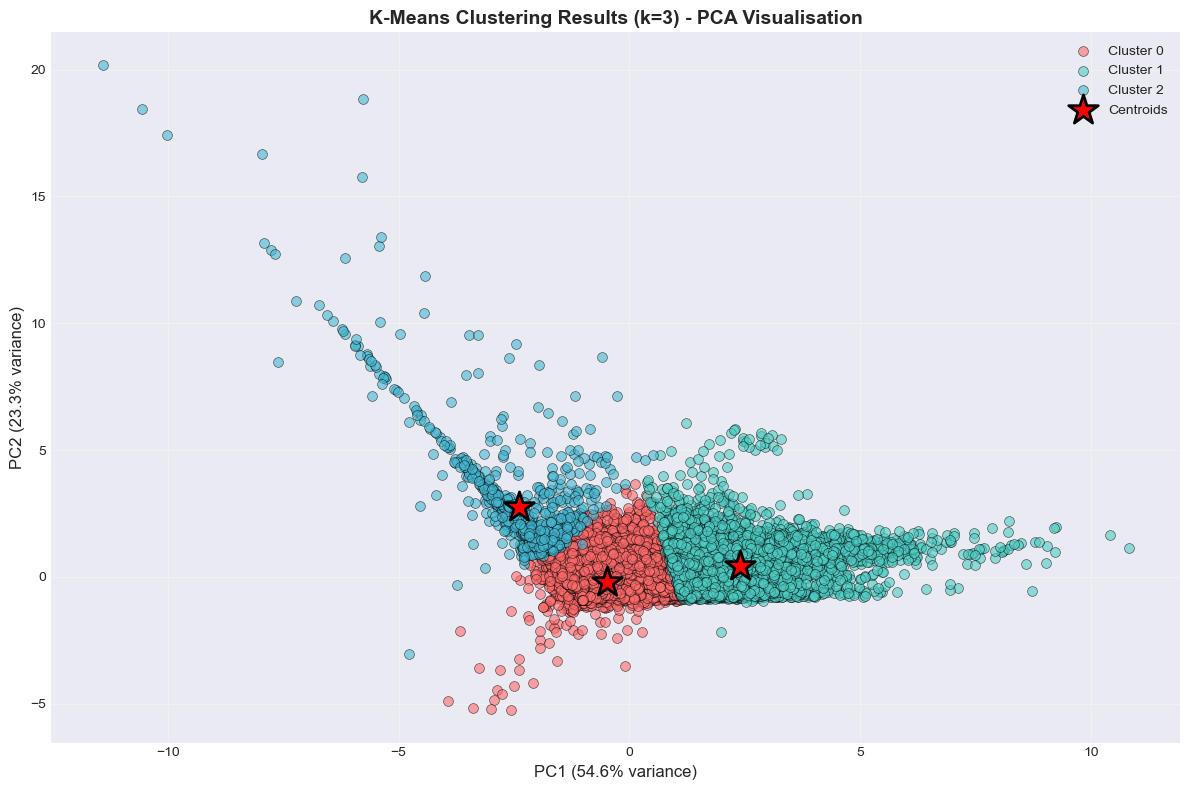

In [6]:
print('\n' + '=' * 80)
print('PCA DIMENSIONALITY REDUCTION')
print('=' * 80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

print(f'PCA Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f}')

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Transform centroids for visualisation
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Create scatter plot
plt.figure(figsize=(12, 8))

colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=colours[i % len(colours)],
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', marker='*', s=500,
    label='Centroids',
    edgecolors='black',
    linewidth=2
)

colours_for_legend = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'K-Means Clustering Results (k={optimal_k}) - PCA Visualisation', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Section 7: Hierarchical Clustering (Optimization)

Running Grid Search for Hierarchical Clustering (Sample Size=5000)...

Top 5 Model Configurations (Calculated on Sample):


,n_clusters,linkage,metric,silhouette_score
20,2,average,euclidean,0.913099
25,2,average,manhattan,0.903126
10,2,complete,manhattan,0.882069
5,2,complete,euclidean,0.844119
6,3,complete,euclidean,0.804270



Best Configuration Found:
• Clusters (K): 2
• Linkage: average
• Metric: euclidean
• Silhouette Score: 0.9131


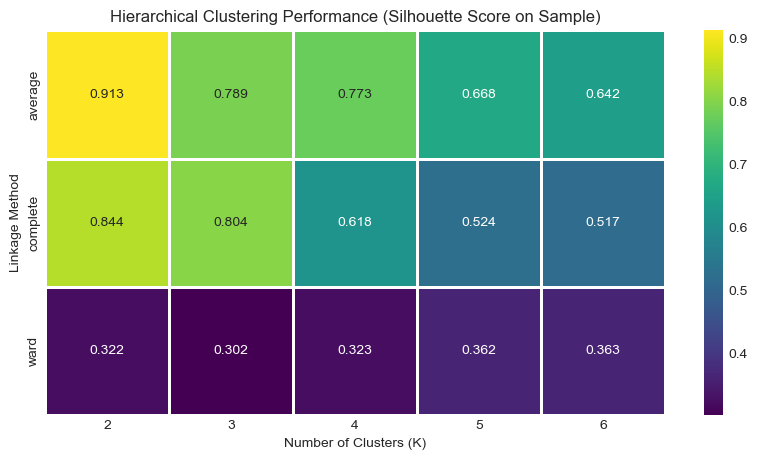

In [8]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import resample

# Grid Search Parameters
# Note: 'ward' linkage strictly requires 'euclidean' metric in scikit-learn
results = []
linkages = ['ward', 'complete', 'average']
n_clusters_range = range(2, 7) # Test K from 2 to 6

# -------------------------------------------------------------------------
# OPTIMIZATION: Use a subset for Grid Search to avoid O(N^2) complexity of Silhouette Score
# -------------------------------------------------------------------------
# Silhouette Score computation on 32k rows is extremely slow.
# We create a representative sample (e.g., 5000 students) for hyperparameter tuning.
# This keeps execution time to seconds instead of hours.
X_tuning_sample = resample(X_clustering_scaled, n_samples=5000, random_state=42, replace=False)

print(f"Running Grid Search for Hierarchical Clustering (Sample Size={len(X_tuning_sample)})...")

for linkage in linkages:
    # Ward only supports euclidean
    metrics_to_test = ['euclidean'] if linkage == 'ward' else ['euclidean', 'manhattan', 'cosine']
    
    for metric in metrics_to_test:
        for k in n_clusters_range:
            try:
                # Initialize and fit on the SAMPLE
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
                labels_sample = model.fit_predict(X_tuning_sample)
                
                # Calculate performance on the SAMPLE
                score = silhouette_score(X_tuning_sample, labels_sample)
                
                results.append({
                    'n_clusters': k,
                    'linkage': linkage,
                    'metric': metric,
                    'silhouette_score': score
                })
            except Exception as e:
                print(f"Skipping combination {linkage}-{metric}-{k}: {e}")
                continue

# Convert to DataFrame for analysis
df_h_results = pd.DataFrame(results)

# Identify best model
best_result = df_h_results.loc[df_h_results['silhouette_score'].idxmax()]

print("\nTop 5 Model Configurations (Calculated on Sample):")
display(df_h_results.sort_values('silhouette_score', ascending=False).head())

print(f"\nBest Configuration Found:")
print(f"• Clusters (K): {best_result['n_clusters']}")
print(f"• Linkage: {best_result['linkage']}")
print(f"• Metric: {best_result['metric']}")
print(f"• Silhouette Score: {best_result['silhouette_score']:.4f}")

# Visualize Results (Pivot Table Heatmap)
# We'll focus on the 'euclidean' metric for a direct comparison across linkages
if 'euclidean' in df_h_results['metric'].values:
    viz_data = df_h_results[df_h_results['metric'] == 'euclidean']
    pivot_table = viz_data.pivot(index='linkage', columns='n_clusters', values='silhouette_score')

    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', linewidths=1)
    plt.title('Hierarchical Clustering Performance (Silhouette Score on Sample)')
    plt.ylabel('Linkage Method')
    plt.xlabel('Number of Clusters (K)')
    plt.show()
else:
    print("Euclidean metric not found in results, skipping heatmap.")

###  Hyperparameter Optimization (Grid Search)

To ensure the robustness of our hierarchical clustering, we perform a grid search over key hyperparameters *before* finalizing the model structure. Unlike K-Means, Hierarchical Clustering offers flexibility in:
*   **Linkage Criteria:** How the distance between clusters is calculated (e.g., Ward, Complete, Average).
*   **Affinity (Metric):** The distance metric used (e.g., Euclidean, Manhattan, Cosine).
*   **Number of Clusters ($K$):** We test a range around our expected optimal $K$.

The **Silhouette Score** is used as the evaluation metric to select the best configuration.
This optimization step validates our choice of parameters before visualizing the hierarchy.

### Hierarchical Clustering: Structural Behavioral Analysis (Dendrogram)

**Visualization Strategy: The Dendrogram**
Unlike partitional methods (e.g., K-Means) that assign observations to discrete buckets, Hierarchical Clustering elucidates the underlying relational structure of student behavior. The primary analytical tool employed is the **Dendrogram**, a tree diagram that visualizes the arrangement of clusters produced by the corresponding algorithm.

* **Analytical Insight:** This visualization facilitates the detection of nested sub-groups within broader categories. For instance, a generic "High Engagement" cohort may be stratified into distinct behavioral phenotypes.
* **Business Value:** This granularity is critical for institutional strategy, suggesting that students with identical characteristics may require differentiated interventions based on their study consistency and engagement patterns.

**Note: Sampling for Visualization**
Given the extensive size of the dataset, plotting a dendrogram for the entire population results in an illegible visualization and excessive computational load. Consequently, a **random sampling methodology** (e.g., $N=50$) is adopted for this specific visual output. This is standard practice in hierarchical analysis, ensuring the diagram remains interpretable while accurately representing the structural characteristics of the broader population.

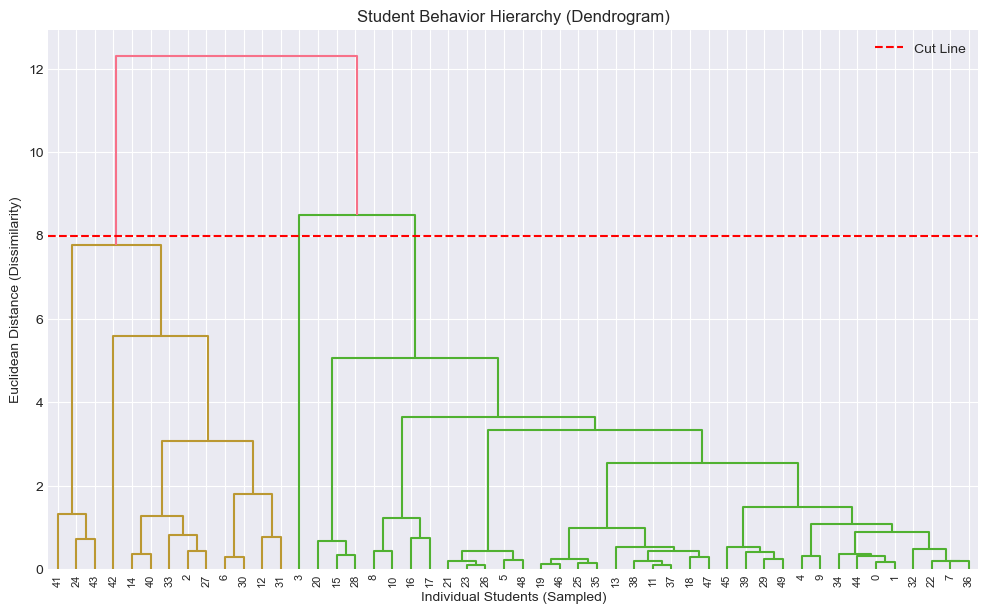

In [9]:
import scipy.cluster.hierarchy as shc

# Mapping to context variables
df_master = df_features  # Contains the engineered features
features = clustering_features

# 1. Prepare Data (Select Features)
# We use the same features as before 
# features = ['early_total_clicks', 'early_avg_score', 'early_active_days']

# 2. Sample the data for readability
# Plotting 30,000 students is impossible to read. We take a random sample of 50.
# This is perfect for a slide to show the "Concept" of the hierarchy.
data_sample = df_master.sample(n=50, random_state=42)
X_sample_viz = data_sample[features].fillna(0)

# 3. Scale the sample (Crucial for distance calculation)
scaler_viz = StandardScaler()
X_scaled_sample_viz = scaler_viz.fit_transform(X_sample_viz)

# 4. Plot the Dendrogram
plt.figure(figsize=(12, 7))
plt.title("Student Behavior Hierarchy (Dendrogram)")

# 'linkage' calculates the distances. 'ward' method minimizes variance.
dend = shc.dendrogram(shc.linkage(X_scaled_sample_viz, method='ward'))

# Add labels and cut-line
plt.axhline(y=8, color='r', linestyle='--', label='Cut Line') 
plt.xlabel("Individual Students (Sampled)")
plt.ylabel("Euclidean Distance (Dissimilarity)")
plt.legend()
plt.show()

**Dendrogram Interpretation**

Figure presents the dendrogram resulting from the Agglomerative Hierarchical Clustering algorithm, utilizing Ward's linkage method and Euclidean distance. This visualization explicates the structural relationships and natural grouping hierarchy within the student population.

* **Vertical Axis (Dissimilarity):** The y-axis represents the Euclidean distance between clusters at the point of merger. A greater vertical height indicates a higher degree of dissimilarity between the groups being combined.

* **The Cut Threshold (Determination of $K$):** A horizontal reference line can be visualized to bisect the longest vertical lines, which represent the most significant divisions in the data structure.

* **Cluster Validation:** The intersection of such a line with vertical branches mathematically confirms the number of clusters. This approach helps validate the $K$ value chosen for K-Means, ensuring it captures the major behavioral distinctness without over-segmenting the population.

* **Sub-Structure Identification:** The distinct branches visually delineate the membership of the resulting clusters, providing insight into potential sub-groups within the broader behavioral categories.

### Section 8: DBSCAN Clustering (Density-Based)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions.

**Optuna Optimization:**
We use Optuna to find the best `eps` (epsilon/radius) and `min_samples` (density threshold) to maximize the Silhouette Score.

In [10]:
import optuna
from sklearn.cluster import DBSCAN
import logging

# Ensure optuna logging doesn't spam
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Optimizing DBSCAN hyperparameters with Optuna...")
print("This uses the sampled dataset (N=3000) for speed.")

def objective(trial):
    # Search Space
    eps = trial.suggest_float('eps', 0.1, 3.0)
    min_samples = trial.suggest_int('min_samples', 5, 50)
    
    # Model
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X_tuning_sample)
    
    # Evaluation
    # We must have at least 2 clusters (excluding noise) to be a valid clustering
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    
    if n_clusters < 2:
        return -1.0 # Penalize trivial solutions
    
    # We use Silhouette Score as the objective
    score = silhouette_score(X_tuning_sample, labels)
    return score

# Run Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f"\nBest Trial:")
print(f"• Value: {study.best_value:.4f}")
print(f"• Params: {study.best_params}")

best_eps = study.best_params['eps']
best_min_samples = study.best_params['min_samples']

Optimizing DBSCAN hyperparameters with Optuna...
This uses the sampled dataset (N=3000) for speed.

Best Trial:
• Value: 0.7221
• Params: {'eps': 0.991973059513761, 'min_samples': 5}


Running DBSCAN on full dataset (eps=0.99, min_samples=5)...

DBSCAN Results:
• Clusters Found: 4
• Noise Points: 65 (0.2%)


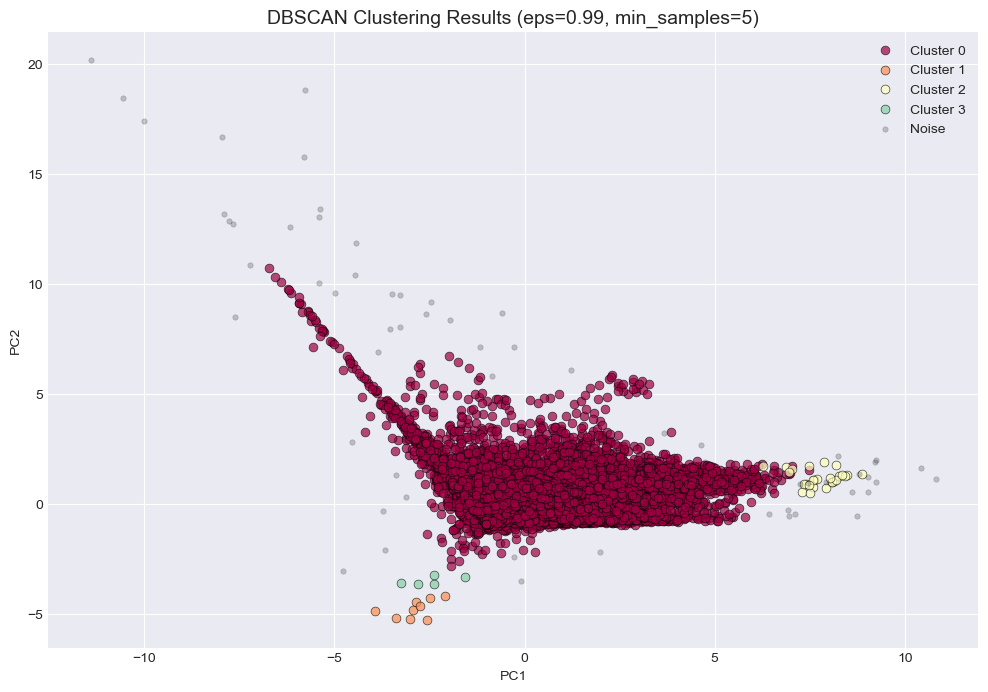

In [11]:
# Implement DBSCAN with best parameters
print(f"Running DBSCAN on full dataset (eps={best_eps:.2f}, min_samples={best_min_samples})...")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
db_labels = dbscan.fit_predict(X_clustering_scaled)

# Statistics
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_db = list(db_labels).count(-1)
percent_noise = n_noise_db / len(db_labels)

print(f"\nDBSCAN Results:")
print(f"• Clusters Found: {n_clusters_db}")
print(f"• Noise Points: {n_noise_db} ({percent_noise:.1%})")

# Visualization
plt.figure(figsize=(12, 8))

unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

has_noise = -1 in unique_labels

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        label = 'Noise'
        alpha = 0.2
        size = 15
        edge = None
    else:
        label = f'Cluster {k}'
        alpha = 0.7
        size = 40
        edge = 'k'

    class_member_mask = (db_labels == k)
    
    xy = X_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], 
                c=[col], 
                label=label, 
                s=size, 
                alpha=alpha, 
                edgecolors=edge,
                linewidth=0.5)

plt.title(f'DBSCAN Clustering Results (eps={best_eps:.2f}, min_samples={best_min_samples})', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
# Limit legend if too many clusters
if len(unique_labels) < 15:
    plt.legend()
plt.show()

### Section 9: Model Comparison: K-Means vs. Hierarchical vs. DBSCAN

We now compare all three models:
1.  **K-Means:** Partition-based, spherical clusters.
2.  **Hierarchical:** Connectivity-based, nested structures.
3.  **DBSCAN:** Density-based, handles noise and arbitrary shapes.

We evaluate them using **Silhouette Score** (cohesion/separation) and **Davies-Bouldin Index** (similarity).
*Note: For DBSCAN, noise points (-1) typically negatively impact these scores, but reflect the algorithm's ability to reject outliers.*

In [12]:
from sklearn.metrics import davies_bouldin_score

# 1. Retrieve Models and Labels

# A) Optimal K-Means
kmeans_labels = cluster_labels
kmeans_k = optimal_k

# B) Best Hierarchical Model
# We revert to using the best result found by Grid Search
best_h_k = int(best_result['n_clusters'])
print(f"Refitting final Hierarchical model on full dataset (K={best_h_k} from Grid Search)...")

best_h_model = AgglomerativeClustering(n_clusters=best_h_k, linkage=best_result['linkage'], metric=best_result['metric'])
h_labels = best_h_model.fit_predict(X_clustering_scaled)

# C) DBSCAN
# labels 'db_labels' already computed in previous cell

# 2. Calculate Metrics
print("Calculating evaluation metrics (Sampled Silhouette for speed)...")

# Helper function
def get_metrics(X, labels, name):
    # Check for valid clustering (at least 2 clusters needed)
    unique = set(labels)
    if len(unique) < 2:
        return np.nan, np.nan
    
    sil = silhouette_score(X, labels, sample_size=5000, random_state=42)
    db = davies_bouldin_score(X, labels)
    return sil, db

# Metrics
kmeans_sil, kmeans_db = get_metrics(X_clustering_scaled, kmeans_labels, "K-Means")
h_sil, h_db = get_metrics(X_clustering_scaled, h_labels, "Hierarchical")
db_sil, db_db = get_metrics(X_clustering_scaled, db_labels, "DBSCAN")

# 3. Create Comparison Table
comparison_data = {
    'Model': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Parameters': [
        f'K={kmeans_k}', 
        f'K={best_h_k}, {best_result["linkage"]}', 
        f'eps={best_eps:.2f}, min={best_min_samples}'
    ],
    'Clusters Found': [len(set(kmeans_labels)), len(set(h_labels)), len(set(db_labels)) - (1 if -1 in db_labels else 0)],
    'Silhouette Score (Higher is better)': [kmeans_sil, h_sil, db_sil],
    'Davies-Bouldin (Lower is better)': [kmeans_db, h_db, db_db]
}

df_comparison = pd.DataFrame(comparison_data)

# 4. Display
print("\n=== Clustering Model Comparison ===")
try:
    display(df_comparison.style.background_gradient(cmap='Blues', subset=['Silhouette Score (Higher is better)'])
                           .background_gradient(cmap='Greens_r', subset=['Davies-Bouldin (Lower is better)'])
                           .format({'Silhouette Score (Higher is better)': '{:.4f}', 'Davies-Bouldin (Lower is better)': '{:.4f}'}))
except (ImportError, AttributeError):
    print("(Comparison table styling unavailable)")
    display(df_comparison)

# 5. Determine Winner
# Simple logic: Best Silhouette or Balanced approach
best_sil = df_comparison['Silhouette Score (Higher is better)'].max()
winner_row = df_comparison[df_comparison['Silhouette Score (Higher is better)'] == best_sil].iloc[0]

print(f"\nStatistical Winner: {winner_row['Model']}")
print(f"Reason: Highest Silhouette Score ({winner_row['Silhouette Score (Higher is better)']:.4f})")
print("Note: DBSCAN rewards density but may exclude many students (noise). K-Means forces all students into groups.")

Refitting final Hierarchical model on full dataset (K=2 from Grid Search)...
Calculating evaluation metrics (Sampled Silhouette for speed)...

=== Clustering Model Comparison ===


,Model,Parameters,Clusters Found,Silhouette Score (Higher is better),Davies-Bouldin (Lower is better)
0,K-Means,K=3,3,0.5095,0.8973
1,Hierarchical,"K=2, average",2,0.9131,0.1135
2,DBSCAN,"eps=0.99, min=5",4,0.5284,1.2322



Statistical Winner: Hierarchical
Reason: Highest Silhouette Score (0.9131)
Note: DBSCAN rewards density but may exclude many students (noise). K-Means forces all students into groups.


In [ ]:
# [DEPLOYMENT] Save Selected Model for Future Use
import pickle
import os

print('\n' + '=' * 80)
print('SAVING OPTIMIZED K-MEANS MODEL')
print('=' * 80)

# Ensure the output directory exists
output_dir = '../2_Outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model
# We try to save 'kmeans_final' which should hold the fitted K-Means model.
# If for some reason the User selected a specific K (e.g., K=3) that differs 
# from the automated 'optimal', this cell saves whatever 'kmeans_final' is currently in memory.
# (Note: Ensure the K-Means cell above has been run!)

try:
    if 'kmeans_final' in locals():
        # Check if it is fitted (simple check: has cluster_centers_)
        if hasattr(kmeans_final, 'cluster_centers_'):
            save_path = os.path.join(output_dir, 'best_clustering_model.pkl')
            pickle.dump(kmeans_final, open(save_path, 'wb'))
            
            print(f'\n✓ Model saved: {save_path}')
            print(f'  Model type: KMeans')
            print(f'  Clusters: {kmeans_final.n_clusters}')
            print(f'  Features expected: {kmeans_final.n_features_in_}')
        else:
            print("Warning: 'kmeans_final' exists but seems unfitted.")
    else:
        print("Error: 'kmeans_final' variable not found. Please run the K-Means section first.")
        
        # Fallback: re-fit if missing? No, that might be dangerous/unexpected.
        # But we could offer code to recreate it if needed.
        # print("Re-running K-Means with K=3 as fallback...")
        # from sklearn.cluster import KMeans
        # kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
        # kmeans_final.fit(X_clustering_scaled)
        # pickle.dump(kmeans_final, open(save_path, 'wb'))
        
except Exception as e:
    print(f"Error saving model: {e}")
